# Flood mapping

This notebook aims to step through the same process as Stefania's MATLAB code.

In [57]:
import datacube, rasterio, numpy as np, matplotlib.pyplot as plt, xarray, pandas, scipy.ndimage, scipy.optimize

In [2]:
lat, lon = -27.1544, 149.0677 # surat
lat, lon = -28.034167, 148.581667 # st george

radius = 0.08

In [3]:
threshold = dict(wofs_persistent = 0.8,
                 wofs_historic = 0.001)

## Loading input data

Initial steps are to load the relevant data (and ancilliaries).

In [4]:
prodcube = datacube.Datacube()

In [5]:
sarcube = datacube.Datacube(config={'db_hostname': 'agdcdev-db.nci.org.au',
                                    'db_port': 6432,
                                    'db_database': 'radar_test'})

In [43]:
wofs_summary = prodcube.load(product='wofs_summary', lat=(lat-radius,lat+radius), lon=(lon-radius,lon+radius)
                            ).isel(time=0)

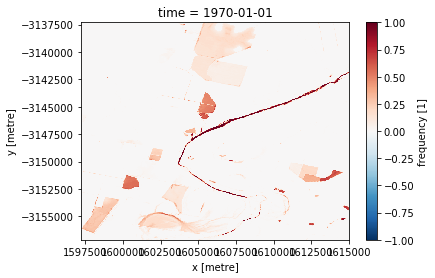

In [44]:
wofs_summary.frequency.plot()

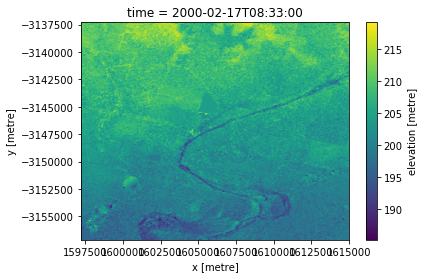

In [8]:
dem = prodcube.load(product='dsm1sv10', like=wofs_summary, time=('1900', '2030'))
dem.elevation.plot()

In [9]:
len(sarcube.find_datasets(product='s1_gamma0_scene', like=wofs_summary, time=('1900', '2030')))

60

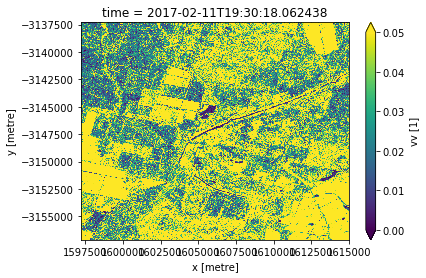

In [10]:
sar = sarcube.load(product='s1_gamma0_scene', like=wofs_summary, time=('2017-02-11', '2017-02-12'), group_by='solar_day')
sar.vv.plot(vmin=0, vmax=0.05)

## Pre-processing SAR data
- Speckle filter (Lee)
- Convert to Decibels units (logarithmic)

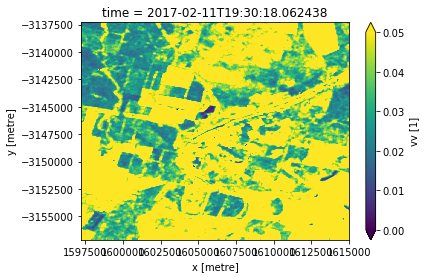

In [35]:
def lee_filter(img, size):
    from scipy.ndimage.filters import uniform_filter
    from scipy.ndimage.measurements import variance

    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

filtered = sar.isel(time=0).vv.copy(deep=True)
filtered.data = lee_filter(filtered.data, 7)
filtered.plot(vmin=0, vmax=0.05)

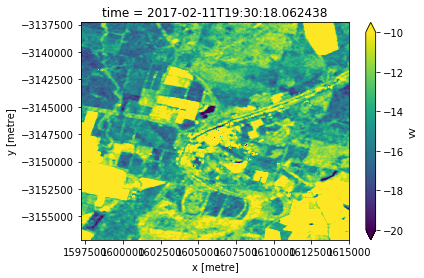

In [40]:
db = 10 * np.log10(filtered)
db.plot(vmin=-20, vmax=-10)

## Open water analysis

The first step chooses a threshold based on a comparison of backscatter statistics, between the areas that are or are not frequently inundated according to the wofs summary.

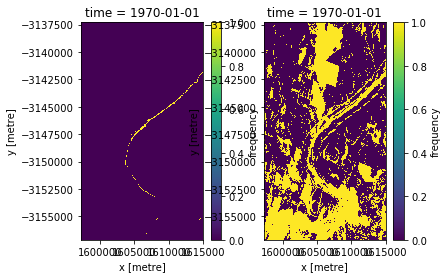

In [45]:
persistent = wofs_summary.frequency > threshold['wofs_persistent']
historic = wofs_summary.frequency > threshold['wofs_historic']

persistent.plot(ax=plt.subplot(1,2,1))
historic.plot(ax=plt.subplot(1,2,2))

First approach fits a Gaussian.

-13.138936 1.8442336
-12.853659791566326 1.4206355029170017


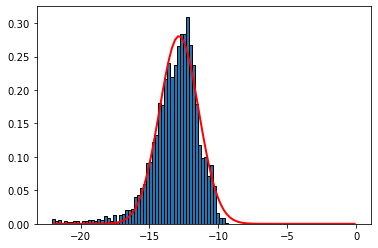

In [100]:
def gaussian(population, nbins=100):
    counts, edges = np.histogram(population, np.linspace(np.nanmin(population), 0, nbins + 1), density=True)
    centres = 0.5 * (edges[:-1] + edges[1:])
    
    mean = np.nanmean(population) # initial fit
    std = np.nanstd(population)
    
    print(mean, std)
    
    def f(x, mean, sigma):
        return np.exp(-0.5 * ((x - mean)/sigma)**2) / (sigma * (2*np.pi)**0.5)    
    mean, std = scipy.optimize.curve_fit(f, centres, counts, p0=[mean, std])[0] # histogram fit
    
    print(mean, std)
    
    plt.hist(edges[:-1], edges, weights=counts, edgecolor='k')
    plt.plot(centres, f(centres, mean, std), color='r', linewidth=2)

gaussian(db.values[persistent.values])

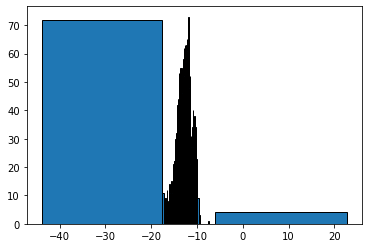

In [48]:
def adaptive(control, test, nbins=100):
    edges = np.nanquantile(control, np.linspace(0, 1, nbins + 1))
    counts = np.histogram(test, edges)[0]
    plt.hist(edges[:-1], edges, weights=counts, edgecolor='k')
    #plt.ylim([0, 900])
    #plt.xlim([-30, 0])
adaptive(db.values[~persistent.values], db.values[persistent.values])